In [1]:
%matplotlib inline
from __future__ import division
from matplotlib import pyplot as plt
import numpy as np
import pymc3 as pm
import scipy as sp
import seaborn as sns
from theano import tensor as tt
import pandas as pd
blue, *_ = sns.color_palette()
SEED = 5132290 # from random.org

np.random.seed(SEED)

WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named 'mkl'


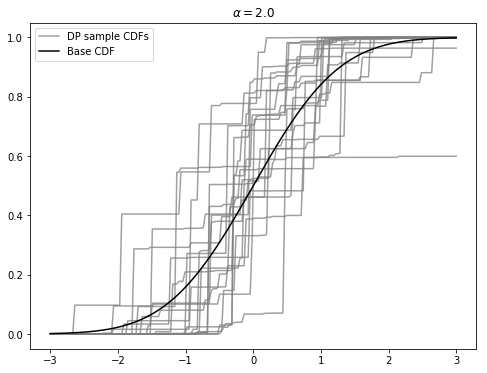

In [2]:
N = 20
K = 30

alpha = 2.
P0 = sp.stats.norm

beta = sp.stats.beta.rvs(1, alpha, size=(N, K))
w = np.empty_like(beta)
w[:, 0] = beta[:, 0]
w[:, 1:] = beta[:, 1:] * (1 - beta[:, :-1]).cumprod(axis=1)

omega = P0.rvs(size=(N, K))

x_plot = np.linspace(-3, 3, 200)

sample_cdfs = (w[..., np.newaxis] * np.less.outer(omega, x_plot)).sum(axis=1)

fig, ax = plt.subplots(figsize=(8, 6))

ax.plot(x_plot, sample_cdfs[0], c='gray', alpha=0.75,
        label='DP sample CDFs');
ax.plot(x_plot, sample_cdfs[1:].T, c='gray', alpha=0.75);
ax.plot(x_plot, P0.cdf(x_plot), c='k', label='Base CDF');

ax.set_title(r'$\alpha = {}$'.format(alpha));
ax.legend(loc=2);

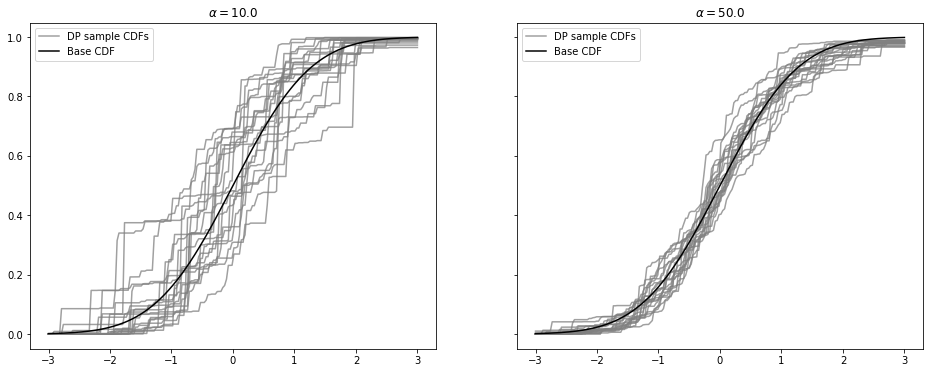

In [3]:
fig, (l_ax, r_ax) = plt.subplots(ncols=2, sharex=True, sharey=True, figsize=(16, 6))

K = 50
alpha = 10.

beta = sp.stats.beta.rvs(1, alpha, size=(N, K))
w = np.empty_like(beta)
w[:, 0] = beta[:, 0]
w[:, 1:] = beta[:, 1:] * (1 - beta[:, :-1]).cumprod(axis=1)

omega = P0.rvs(size=(N, K))

sample_cdfs = (w[..., np.newaxis] * np.less.outer(omega, x_plot)).sum(axis=1)

l_ax.plot(x_plot, sample_cdfs[0], c='gray', alpha=0.75,
          label='DP sample CDFs');
l_ax.plot(x_plot, sample_cdfs[1:].T, c='gray', alpha=0.75);
l_ax.plot(x_plot, P0.cdf(x_plot), c='k', label='Base CDF');

l_ax.set_title(r'$\alpha = {}$'.format(alpha));
l_ax.legend(loc=2);

K = 200
alpha = 50.

beta = sp.stats.beta.rvs(1, alpha, size=(N, K))
w = np.empty_like(beta)
w[:, 0] = beta[:, 0]
w[:, 1:] = beta[:, 1:] * (1 - beta[:, :-1]).cumprod(axis=1)

omega = P0.rvs(size=(N, K))

sample_cdfs = (w[..., np.newaxis] * np.less.outer(omega, x_plot)).sum(axis=1)

r_ax.plot(x_plot, sample_cdfs[0], c='gray', alpha=0.75,
          label='DP sample CDFs');
r_ax.plot(x_plot, sample_cdfs[1:].T, c='gray', alpha=0.75);
r_ax.plot(x_plot, P0.cdf(x_plot), c='k', label='Base CDF');

r_ax.set_title(r'$\alpha = {}$'.format(alpha));
r_ax.legend(loc=2);

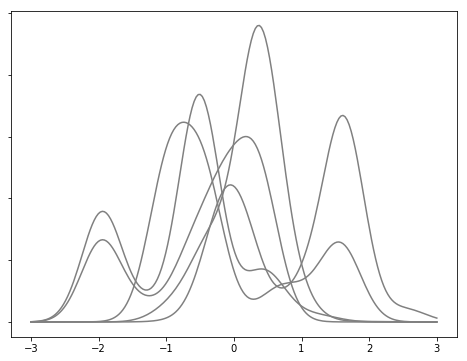

In [4]:
N = 5
K = 30

alpha = 2
P0 = sp.stats.norm
f = lambda x, theta: sp.stats.norm.pdf(x, theta, 0.3)

beta = sp.stats.beta.rvs(1, alpha, size=(N, K))
w = np.empty_like(beta)
w[:, 0] = beta[:, 0]
w[:, 1:] = beta[:, 1:] * (1 - beta[:, :-1]).cumprod(axis=1)

theta = P0.rvs(size=(N, K))

dpm_pdf_components = f(x_plot[np.newaxis, np.newaxis, :], theta[..., np.newaxis])
dpm_pdfs = (w[..., np.newaxis] * dpm_pdf_components).sum(axis=1)

fig, ax = plt.subplots(figsize=(8, 6))

ax.plot(x_plot, dpm_pdfs.T, c='gray');

ax.set_yticklabels([]);

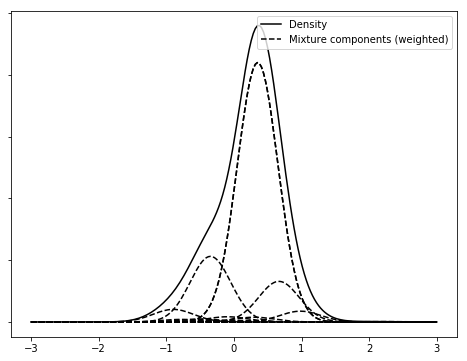

In [5]:
fig, ax = plt.subplots(figsize=(8, 6))

ix = 1

ax.plot(x_plot, dpm_pdfs[ix], c='k', label='Density');
ax.plot(x_plot, (w[..., np.newaxis] * dpm_pdf_components)[ix, 0],
        '--', c='k', label='Mixture components (weighted)');
ax.plot(x_plot, (w[..., np.newaxis] * dpm_pdf_components)[ix].T,
        '--', c='k');

ax.set_yticklabels([]);
ax.legend(loc=1);

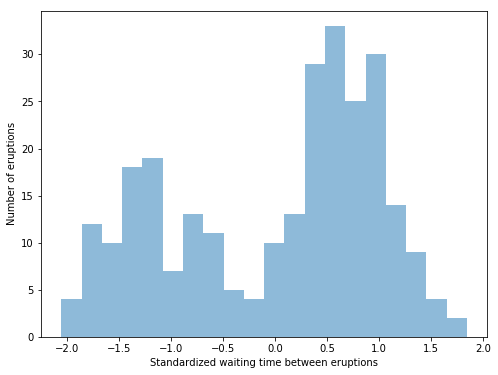

In [6]:
old_faithful_df = pd.read_csv(pm.get_data('old_faithful.csv'))
old_faithful_df['std_waiting'] = (old_faithful_df.waiting - old_faithful_df.waiting.mean()) / old_faithful_df.waiting.std()
fig, ax = plt.subplots(figsize=(8, 6))

n_bins = 20
ax.hist(old_faithful_df.std_waiting, bins=n_bins, color=blue, lw=0, alpha=0.5);

ax.set_xlabel('Standardized waiting time between eruptions');
ax.set_ylabel('Number of eruptions');

In [51]:
N = old_faithful_df.shape[0]

K = 30

def stick_breaking(beta):
    portion_remaining = tt.concatenate([[1], tt.extra_ops.cumprod(1 - beta)[:-1]])

    return beta * portion_remaining


In [8]:
with pm.Model() as model:
    alpha = pm.Gamma('alpha', 1., 1.)
    beta = pm.Beta('beta', 1., alpha, shape=K)
    w = pm.Deterministic('w', stick_breaking(beta))

    tau = pm.Gamma('tau', 1., 1., shape=K)
    lambda_ = pm.Uniform('lambda', 0, 5, shape=K)
    mu = pm.Normal('mu', 0, tau=lambda_ * tau, shape=K)
    obs = pm.NormalMixture('obs', w, mu, tau=lambda_ * tau,
                           observed=old_faithful_df.std_waiting.values)

In [9]:
with model:
    trace = pm.sample(1000, random_seed=SEED)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu, lambda, tau, beta, alpha]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:49<00:00, 60.40draws/s] 
/Users/inti.pedroso/anaconda2/envs/pymc3/lib/python3.6/site-packages/mkl_fft/_numpy_fft.py:1044: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.rfftn_numpy(a, s, axes)
There were 93 divergences after tuning. Increase `target_accept` or reparameterize.
There were 168 divergences after tuning. Increase `target_accept` or reparameterize.
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


/Users/inti.pedroso/anaconda2/envs/pymc3/lib/python3.6/site-packages/matplotlib/axes/_base.py:3449: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')


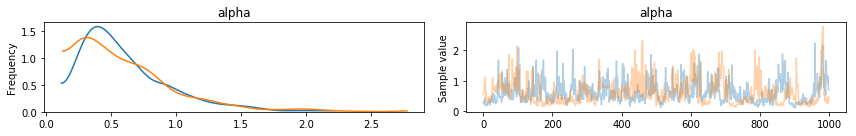

In [10]:
pm.traceplot(trace, varnames=['alpha']);


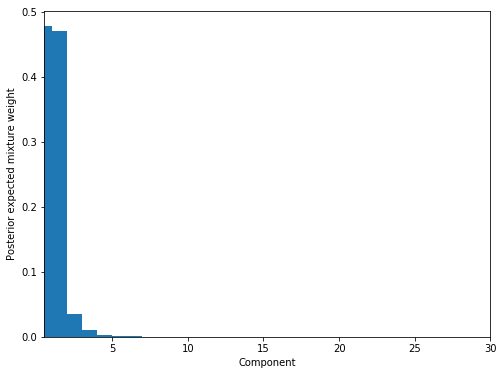

In [11]:
fig, ax = plt.subplots(figsize=(8, 6))

plot_w = np.arange(K) + 1

ax.bar(plot_w - 0.5, trace['w'].mean(axis=0), width=1., lw=0);

ax.set_xlim(0.5, K);
ax.set_xlabel('Component');

ax.set_ylabel('Posterior expected mixture weight');

NameError: name 'values' is not defined

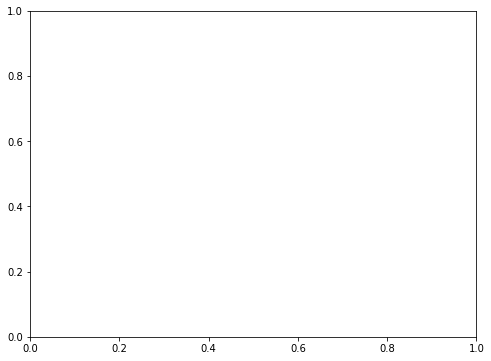

In [12]:
post_pdf_contribs = sp.stats.norm.pdf(np.atleast_3d(x_plot),
                                      trace['mu'][:, np.newaxis, :],
                                      1. / np.sqrt(trace['lambda'] * trace['tau'])[:, np.newaxis, :])
post_pdfs = (trace['w'][:, np.newaxis, :] * post_pdf_contribs).sum(axis=-1)

post_pdf_low, post_pdf_high = np.percentile(post_pdfs, [2.5, 97.5], axis=0)

fig, ax = plt.subplots(figsize=(8, 6))

n_bins = 20
ax.hist(values, bins=n_bins, normed=True,
        color=blue, lw=0, alpha=0.5);

ax.fill_between(x_plot, post_pdf_low, post_pdf_high,
                color='gray', alpha=0.45);
ax.plot(x_plot, post_pdfs[0],
        c='gray', label='Posterior sample densities');
ax.plot(x_plot, post_pdfs[::100].T, c='gray');
ax.plot(x_plot, post_pdfs.mean(axis=0),
        c='k', label='Posterior expected density');

ax.set_xlabel('Standardized waiting time between eruptions');

ax.set_yticklabels([]);
ax.set_ylabel('Density');

ax.legend(loc=2);

In [13]:
folders = !ls /Users/inti.pedroso/DATA/ASE/phaser_old/
data = pd.concat([ pd.read_table("".join(["/Users/inti.pedroso/DATA/ASE/phaser_old/",f,"/",f,".phaser_ase.gene.txt"])) for f in folders ])



In [14]:
#data = pd.read_table("/Users/inti.pedroso/DATA/ASE/phaser/ERR883767/ERR883767.phaser_ase.gene.txt")
data.head()
data2 = data[data["totalCount"] > 10]
data2.shape

(11781, 12)

In [15]:
data2.head()

,contig,start,stop,name,aCount,bCount,totalCount,log2_aFC,n_variants,variants,gw_phased,bam
0,B07,55918,262024,LOC100650155,13,7,20,0.893085,3,"B07_125190_T_C,B07_125307_G_A,B07_125324_C_T",0,SRR5125120
2,B07,272283,274410,LOC100645164,28,39,67,-0.478047,1,B07_272438_C_T,0,SRR5125120
3,B07,274926,279735,LOC100642756,36,39,75,-0.115477,1,B07_276869_C_T,0,SRR5125120
8,B07,300751,312616,LOC100646658,132,97,229,0.444481,7,"B07_305645_G_A,B07_305648_C_G,B07_305784_C_T,B...",0,SRR5125120
9,B07,312551,315414,LOC105665861,12,10,22,0.263034,2,"B07_312966_C_T,B07_313076_T_G",0,SRR5125120


In [ ]:
values = data2.log2_aFC.values[:3000]
values = values[ values < np.infty]
values = values[ values > -np.infty]

K = 30

with pm.Model() as model:
    alpha = pm.Gamma('alpha', 1., 1.)
    beta = pm.Beta('beta', 1., alpha, shape=K)
    w = pm.Deterministic('w', stick_breaking(beta))

    tau = pm.Gamma('tau', 1., 1., shape=K)
    lambda_ = pm.Uniform('lambda', 0, 5, shape=K)
    mu = pm.Normal('mu', 0, tau=lambda_ * tau, shape=K)
    obs = pm.NormalMixture('obs', w, mu, tau=lambda_ * tau,
                           observed=values)

In [ ]:
with model:
    trace = pm.sample(1000, random_seed=SEED)

In [ ]:
values = data2.log2_aFC.values[:3000]
values = values[ values < np.infty]
values = values[ values > -np.infty]

plt.hist(values)

In [ ]:
values = data2.log2_aFC.values
values = values[ values < np.infty]
values = values[ values > -np.infty]

K = 11

X = pm.Minibatch(values, batch_size=1000)


with pm.Model() as model:
    alpha = pm.Gamma('alpha', 1., 1.)
    beta = pm.Beta('beta', 1., alpha, shape=K)
    w = pm.Deterministic('w', stick_breaking(beta))

    tau = pm.Gamma('tau', 1., 1., shape=K)
    lambda_ = pm.Uniform('lambda', 0, 5, shape=K)
    mu = pm.Normal('mu', 0, tau=lambda_ * tau, shape=K)
    obs = pm.NormalMixture('obs', w, mu, tau=lambda_ * tau,
                           observed=X)
    
with model:
    advifit = pm.fit()

In [ ]:
with model:
    advifit = pm.fit()

In [ ]:
with model:
    svgd_approx = pm.fit(300, method='svgd', inf_kwargs=dict(n_particles=1000),
                         obj_optimizer=pm.sgd(learning_rate=0.01))

In [ ]:
values.shape

In [ ]:
AR = data2.aCount.values/data2.totalCount.astype(float).values
mean(AR)

In [ ]:
plt.hist(values, bins=50,normed=True)

In [ ]:
#values = data2.log2_aFC.values
values = AR
values = values[ values < 1]
values = values[ values > 0]
#values = np.log(values)
K = 11

X = pm.Minibatch(values, batch_size=1000)

means = get_mu_linear(K)
means

In [ ]:
values

In [ ]:
with pm.Model() as model:
    alpha = pm.Gamma('alpha', 1., 1.)
    beta = pm.Beta('beta', 1., alpha, shape=K)
    w = pm.Deterministic('w', stick_breaking(beta))

    tau = pm.Gamma('tau', 1., 1., shape=K)
    lambda_ = pm.Uniform('lambda', 0, 5, shape=K)
    mu = pm.Normal('mu', means, tau=lambda_ * tau, shape=K)
    obs = pm.NormalMixture('obs', w, mu, tau=lambda_ * tau,
                           observed=X)
  

In [ ]:
  
with model:
    advifit = pm.fit(n=50000)
trace=advifit.sample()



In [ ]:
plt.plot(advifit.hist);


In [ ]:
fig, ax = plt.subplots(figsize=(8, 6))

plot_w = np.arange(K) + 1

ax.bar(plot_w - 0.5, trace['w'].mean(axis=0), width=1., lw=0);

ax.set_xlim(0.5, K);
ax.set_xlabel('Component');

ax.set_ylabel('Posterior expected mixture weight');

In [ ]:
post_pdf_contribs = sp.stats.norm.pdf(np.atleast_3d(x_plot),
                                      trace['mu'][:, np.newaxis, :],
                                      1. / np.sqrt(trace['lambda'] * trace['tau'])[:, np.newaxis, :])
post_pdfs = (trace['w'][:, np.newaxis, :] * post_pdf_contribs).sum(axis=-1)

post_pdf_low, post_pdf_high = np.percentile(post_pdfs, [2.5, 97.5], axis=0)

fig, ax = plt.subplots(figsize=(8, 6))

n_bins = 20
ax.hist(values, bins=n_bins, normed=True,
        color=blue, lw=0, alpha=0.5);

ax.fill_between(x_plot, post_pdf_low, post_pdf_high,
                color='gray', alpha=0.45);
ax.plot(x_plot, post_pdfs[0],
        c='gray', label='Posterior sample densities');
ax.plot(x_plot, post_pdfs[::100].T, c='gray');
ax.plot(x_plot, post_pdfs.mean(axis=0),
        c='k', label='Posterior expected density');

ax.set_xlabel('Standardized waiting time between eruptions');

ax.set_yticklabels([]);
ax.set_ylabel('Density');
ax.set_xlim(0,1)
ax.legend(loc=2);

In [ ]:
trace['mu'].mean(axis=0)

In [ ]:
data2.head()

In [19]:
def get_mu_linear(K=3):
    back = np.sort(np.hstack([np.arange(0,1.0,1.0/(K-1))] + [.99]))
    back[back == 0] = 0.01
    back[back == 1] = 0.99
    #back[back == 0.5] = 0.53


    return back

get_mu_linear(3)

array([0.01, 0.5 , 0.99])

In [20]:
AR = data2.aCount.values/data2.totalCount.astype(float).values

#values = data2.log2_aFC.values
values = AR
values = values[ values < 1]
values = values[ values > 0]
#values = np.log(values)
K = 11

X = pm.Minibatch(values, batch_size=1000)

means = get_mu_linear(K)
means

/Users/inti.pedroso/anaconda2/envs/pymc3/lib/python3.6/site-packages/pymc3/data.py:236: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  self.shared = theano.shared(data[in_memory_slc])


array([0.01, 0.1 , 0.2 , 0.3 , 0.4 , 0.5 , 0.6 , 0.7 , 0.8 , 0.9 , 0.99])

In [83]:
del(BB_model)

In [85]:
from pymc3.distributions.transforms import t_stick_breaking

totalCounts = data2.totalCount.values
counts = totalCounts = data2.aCount.values

K = 11
with pm.Model() as BB_model:
    alpha = pm.Gamma('alpha', 1., 1.)
    beta = pm.Beta('beta', 1., alpha, shape=K)
    w = pm.Deterministic('w', stick_breaking(beta))
    
    #mu = pm.Normal('mu', means, tau=lambda_ * tau, shape=K)
    #obs = pm.NormalMixture('obs', w, mu, tau=lambda_ * tau, observed=X)
    M = pm.Pareto('M', 1.5, 1.0) 
    alpha_ = pm.Deterministic('alpha_',means*M)
    beta_ = pm.Deterministic('beta_',(1.0 - means)*M)

In [82]:
alpha_.shape

Shape.0

In [80]:
with pm.Model() as BB_model:
    
    bb1 = pm.BetaBinomial('bb1' ,alpha=alpha_, beta=beta_, n=totalCounts, shape=(K,))
    #bb2 = pm.BetaBinomial.dist('bb2' ,alpha=100, beta=10, n=totalCounts)

    #bbs = [bb1,bb2] # [ pm.BetaBinomial('bb' + str(i),alpha=means[i]*M, beta=(1-means[i])*M, n=totalCounts) for i in np.arange(K)]
bbs

ValueError: Input dimension mis-match. (input[0].shape[0] = 11781, input[1].shape[0] = 11)

In [68]:
with pm.Model() as BB_model:
    obs = pm.Mixture('obs', 
                     w=w, 
                     comp_dists = bbs, #pm.BetaBinomial.dist(alpha = alpha_,beta = beta_,n = totalCounts), 
                     observed=counts)

AsTensorError: ('Cannot convert <bound method _tensor_py_operators.mean of bb1> to TensorType', <class 'method'>)

In [55]:
len(w)

TypeError: object of type 'TensorVariable' has no len()

In [ ]:
with BB_model:
    advifit = pm.fit(n=50000)
trace=advifit.sample()

In [30]:
stick_breaking(0.5)

Elemwise{mul,no_inplace}.0